<a href="https://colab.research.google.com/github/yuuki-kusumoto/kusumoto/blob/main/simpleMLC_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install MeCab
!pip install mecab-python3
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
aptitude is already the newest version (0.8.10-6ubuntu1).
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 48 not upgraded.
mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the requested version (0.996-5)
mecab-ipadic-utf8 is already installed at the requested version (2.7.0-20070801+main-1)
git is already installed at the requested version (1:2.17.1-1ubuntu0.11)
make is already installed at the requested version (4.1-9.1ubuntu1)
curl is already installed at the requested version (7.58.0-2ubuntu3.18)
xz-utils is already installed at the requested version (5.2.2-1.3ubuntu0.1)
file is already installed at the requested version (1:5.32-2ubuntu0.4)
mecab is already installed at the requested version (0.99

In [ ]:
import numpy as np

!pip install ipadic
!pip install mecab-python3
!pip install unidic-lite
# MeCabとtransformersを用意する
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
# 以下で報告があるようにmecab-python3のバージョンを0.996.5にしないとtokezerで落ちる
# https://stackoverflow.com/questions/62860717/huggingface-for-japanese-tokenizer
!pip install mecab-python3==0.996.5
!pip install unidic-lite # これないとMeCab実行時にエラーで落ちる
!pip install transformers
!pip install "transformers==2.5.1"
!pip install "torchtext== 0.11"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
aptitude is already the newest version (0.8.10-6ubuntu1).
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 48 not upgraded.
mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the requested version (0.996-5)
mecab-ipadic-utf8 is already installed at the requested version (2.7.0-20070801+main-1)
git is already installed at the requested version (1:2.17.1-1ubuntu0.11)
make is already installed at the requested version (4.1-9.1ubuntu1)
curl is already installed at the requested version (7.58.0-2ubuntu3.18)
xz-uti

In [ ]:
import subprocess

cmd='echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
path_neologd = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
                           shell=True).communicate()[0]).decode('utf-8')

import torch
import transformers
from transformers.modeling_bert import BertModel
from transformers.tokenization_bert_japanese import BertJapaneseTokenizer
from transformers import BertJapaneseTokenizer, BertForMaskedLM
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

# パッケージのimport
import numpy as np
import random
import torch.nn as nn
import torch.optim as optim
import torchtext

# 必要なパッケージのimport
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext


! curl http://www.cl.ecei.tohoku.ac.jp/resources/sent_lex/pn.csv.m3.120408.trim > pn.csv


model = BertModel.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')

# model_nameはここから取得(cf. https://huggingface.co/transformers/pretrained_models.html)
model_name = "cl-tohoku/bert-base-japanese"
tokenizer = BertJapaneseTokenizer.from_pretrained(model_name)

import warnings
warnings.filterwarnings('ignore')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  676k  100  676k    0     0   315k      0  0:00:02  0:00:02 --:--:--  315k


Downloading:   0%|          | 0.00/479 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/258k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110 [00:00<?, ?B/s]

In [ ]:
import csv
import pandas as pd
import numpy as np

csvfile = open("drive/My Drive/Travel_version4.csv", encoding="cp932")
All_CATEGORY =  pd.read_csv(csvfile)
All_CATEGORY

#朝食
bre_df = open("drive/My Drive/breakfast_only.csv", encoding="cp932")
bre_CATEGORY =  pd.read_csv(bre_df)

#夕食
din_df = open("drive/My Drive/dinner_only.csv", encoding="cp932")
din_CATEGORY =  pd.read_csv(din_df)

#風呂
bat_df = open("drive/My Drive/bath_only.csv", encoding="cp932")
bat_CATEGORY =  pd.read_csv(bat_df)

#サービス
ser_df = open("drive/My Drive/service_only.csv", encoding="cp932")
ser_CATEGORY =  pd.read_csv(ser_df)

#立地
sta_df = open("drive/My Drive/state_only.csv", encoding="cp932")
sta_CATEGORY =  pd.read_csv(sta_df)

#施設
fac_df = open("drive/My Drive/facility_only.csv", encoding="cp932")
fac_CATEGORY =  pd.read_csv(fac_df)

#部屋
roo_df = open("drive/My Drive/room_only.csv", encoding="cp932")
roo_CATEGORY =  pd.read_csv(roo_df)

In [ ]:
All_CATEGORY2 = All_CATEGORY.sample(frac=1)

# tsvファイルで保存する
tr_df = All_CATEGORY2[:26000]
# 全体の2割の文章数
tr_df = tr_df.sample(frac=1)
len_0_2 = 2000

# 前から2割をテストデータとする
tr_df[:len_0_2].to_csv("./test.tsv", sep='\t', index=False, header=None)
print(tr_df[:len_0_2].shape)

# 前2割からを訓練&検証データとする
tr_df[len_0_2:].to_csv("./train.tsv", sep='\t', index=False, header=None)
print(tr_df[len_0_2:].shape)

def tokenizer_512(input_text):
    """torchtextのtokenizerとして扱えるように、512単語のpytorchでのencodeを定義。ここで[0]を指定し忘れないように"""
    return tokenizer.encode(input_text, max_length=100, return_tensors='pt')[0]


TEXT = torchtext.legacy.data.Field(sequential=True, tokenize=tokenizer_512, use_vocab=False, lower=False,include_lengths=True, batch_first=True, fix_length=100, pad_token=0)
# 注意：tokenize=tokenizer.encodeと、.encodeをつけます。padding[PAD]のindexが0なので、0を指定します。

#ラベルは数字なのでラベル用オブジェクトはsequential = False
LABEL1 = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

#ラベルは数字なのでラベル用オブジェクトはsequential = False
LABEL2 = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

#ラベルは数字なのでラベル用オブジェクトはsequential = False
LABEL3 = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

#ラベルは数字なのでラベル用オブジェクトはsequential = False
LABEL4 = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

#ラベルは数字なのでラベル用オブジェクトはsequential = False
LABEL5 = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

#ラベルは数字なのでラベル用オブジェクトはsequential = False
LABEL6 = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

#ラベルは数字なのでラベル用オブジェクトはsequential = False
LABEL7 = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

#ラベルは数字なのでラベル用オブジェクトはsequential = False
LABEL8 = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

#ラベルは数字なのでラベル用オブジェクトはsequential = False
LABEL9 = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

#ラベルは数字なのでラベル用オブジェクトはsequential = False
LABEL10 = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

#ラベルは数字なのでラベル用オブジェクトはsequential = False
LABEL11 = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

#ラベルは数字なのでラベル用オブジェクトはsequential = False
LABEL12 = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

#ラベルは数字なのでラベル用オブジェクトはsequential = False
LABEL13 = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

#ラベルは数字なのでラベル用オブジェクトはsequential = False
LABEL14 = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

# 乱数シードの固定

import os
import random
import numpy as np
import torch

SEED_VALUE = 1938  # これはなんでも良い
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)  # PyTorchを使う場合

# torchtext.data.Datasetのsplit関数で訓練データと検証データを分ける
# train_eval：4000個、test：2000個

#dataset_train, dataset_eval = dataset_train_eval.split(split_ratio = 1 - 0.2, random_state=random.seed(1234))

# 各tsvファイルを読み込み、分かち書きをしてdatasetに
# train_eval：61300個、test：15324個
dataset_train_eval, dataset_test = torchtext.legacy.data.TabularDataset.splits(
    path='.', train='train.tsv', test='test.tsv', format='tsv', fields=[('Text', TEXT), ('Label1', LABEL1), ('Label2', LABEL2), ('Label3', LABEL3),  ('Label4', LABEL4), ('Label5', LABEL5), ('Label6', LABEL6), ('Label7', LABEL7), ('Label8', LABEL8), ('Label9', LABEL9), ('Label10', LABEL10), ('Label11', LABEL11), ('Label12', LABEL12), ('Label13', LABEL13), ('Label14', LABEL14)])
# torchtext.data.Datasetのsplit関数で訓練データと検証データを分ける
# train_eval：4000個、test：2000個

dataset_train, dataset_eval = dataset_train_eval.split(split_ratio = 1 - 0.25, random_state=random.seed(1234))
dataset_eval, dataset_test = dataset_eval.split(split_ratio = 1 - 0.5, random_state=random.seed(1234))
# datasetの長さを確認してみる
print("train", dataset_train.__len__())
print("eval", dataset_eval.__len__())
print("test", dataset_test.__len__())

# datasetの中身を確認してみる
item = next(iter(dataset_train))
print(item.Text)
print("長さ：", len(item.Text))  # 長さを確認 [CLS]から始まり[SEP]で終わる。512より長いと後ろが切れる
print("ラベル：", item.Label1)

# DataLoaderを作成

batch_size = 4


dl_train = torchtext.legacy.data.Iterator(
    dataset_train, batch_size=batch_size, train=True)

dl_eval = torchtext.legacy.data.Iterator(
    dataset_eval, batch_size=batch_size, train=False, sort=False)

dl_test = torchtext.legacy.data.Iterator(
    dataset_test, batch_size=batch_size, train=False, sort=False)

# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": dl_train, "val": dl_eval}

(2000, 15)
(24000, 15)
train 18000
eval 3000
test 3000
tensor([    2, 18178,   485,    91,  2438,    28,  4613, 28506,    16,   288,
            9,  2283,    12,   517,    16,   546,  1549,    13,  2502,  2610,
            8,     3])
長さ： 22
ラベル： 0


In [ ]:
from torch import nn

class BertForReview(nn.Module):
    '''BERTモデルにレビュー文の2クラスを判定する部分をつなげたモデル'''

    def __init__(self):
        super(BertForReview, self).__init__()

        # BERTモジュール
        #self.bert = model  # 日本語学習済みのBERTモデル

        self.bert = BertModel.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking',
                                              output_attentions=True,
                                              output_hidden_states=True)

        # headにポジネガ予測を追加
        # 入力はBERTの出力特徴量の次元768、出力は14クラス
        #cls層の追加
        self.cls = nn.Linear(in_features=768, out_features=14)
        
        # 重み初期化処理
        nn.init.normal_(self.cls.weight, std=0.02)
        nn.init.normal_(self.cls.bias, 0)    
    
    def forward(self, input_ids):
        '''
        input_ids： [batch_size, sequence_length]の文章の単語IDの羅列
        '''

        # BERTの基本モデル部分の順伝搬
        # 順伝搬させる
        #print("input_ids :", input_ids)
        result = self.bert(input_ids)  # reult は、sequence_output, pooled_output
        #result, _, attentions = self.bert(input_ids, output_attentions=True)

        all_attentions = result[2]
        last_layer_attention = all_attentions[-1]
        hidden_states = result[3]

        #m = nn.Softmax(dim=1)

        #vec1 = self._get_cls_vec(hidden_states[-1])
        # sequence_outputの先頭の単語ベクトルを抜き出す
        vec_0 = result[0]  # 最初の0がsequence_outputを示す
        vec_02 = vec_0[:, 0, :]  # 全バッチ。先頭0番目の単語の全768要素。　つまりclsトークンを獲得している。
        vec_02 = vec_02.view(-1, 768)  # sizeを[batch_size, hidden_size] clsトークン
        #ec_03 = vec_0[:, 0:100, :] #文章の埋め込み表現
        output = self.cls(vec_02)  # 全結合層

        #return vec_02, vec_03, last_layer_attention,hidden_states  #vec_02 : clsトークン, #vec_03 : 文章の特徴量
        oo = nn.Sigmoid()
        
        return oo(output)

# モデル構築
BERT_net = BertForReview()

# 訓練モードに設定
BERT_net.train()

print('ネットワーク設定完了')


# 勾配計算を最後のBertLayerモジュールと追加した分類アダプターのみ実行

# 1. まず全部を、勾配計算Falseにしてしまう
for param in BERT_net.parameters():
    param.requires_grad = False

# 2. BertLayerモジュールの最後を勾配計算ありに変更
for param in BERT_net.bert.encoder.layer[-1].parameters():
    param.requires_grad = True

# 3. 識別器を勾配計算ありに変更
for param in BERT_net.cls.parameters():
    param.requires_grad = True

# BERTの元の部分はファインチューニング
bert_optimizer = optim.Adam([
    {'params': BERT_net.bert.encoder.layer[-1].parameters(), 'lr': 1e-4},
    {'params': BERT_net.cls.parameters(), 'lr': 3e-4}
])

# 損失関数の設定
criterion = nn.BCELoss()


ネットワーク設定完了


In [ ]:
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

In [ ]:
# モデルを学習させる関数を作成
# GPUが使えるかを確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  
print("使用デバイス：", device)
print('-----start-------')

def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # ネットワークをGPUへ
    net.to(device)

    train_loss1 = []
    val_loss1 = []
    F1_list = []
    F1_list2 = []
    
    precision_list1 = []
    precision_list2 = []
    
    recall_list1 = []
    recall_list2 = []

    acc_train_list1 = []
    acc_val_list1 = []

    acc_train_list1 = []
    acc_val_list1 = []

    train_loss2 = []
    val_loss2 = []

    acc_train_list2 = []
    acc_val_list2 = []

    acc_train_list2 = []
    acc_val_list2 = []

    total_label_list = []
    out_list = []

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # ミニバッチのサイズ
    batch_size = dataloaders_dict["train"].batch_size

    # epochのループ
    for epoch in range(num_epochs):
        # epochごとの訓練と検証のループ
        #for phase in ['train', 'val']:
            
            phase="train"

            pred_list = []
            label_list = []

            net.train()  # モデルを訓練モードに
            
            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数
            iteration = 1

            # データローダーからミニバッチを取り出すループ
            for batch in (dataloaders_dict["train"]):
                # batchはTextとLableの辞書型変数

                # GPUが使えるならGPUにデータを送る
                inputs = batch.Text[0].to(device)  # 文章
                labels = batch.Label1.to(device)  # ラベル
                labels2 = batch.Label2.to(device)
                labels3 = batch.Label3.to(device)
                labels4 = batch.Label4.to(device)
                labels5 = batch.Label5.to(device)
                labels6 = batch.Label6.to(device)
                labels7 = batch.Label7.to(device)
                labels8 = batch.Label8.to(device)
                labels9 = batch.Label9.to(device)
                labels10 = batch.Label10.to(device)
                labels11 = batch.Label11.to(device)
                labels12 = batch.Label12.to(device)
                labels13 = batch.Label13.to(device)
                labels14 = batch.Label14.to(device)
                pa = torch.stack([labels, labels2, labels3, labels4, labels5,labels6,labels7,labels8,labels9,labels10, labels11, labels12,labels13,labels14], dim = 1)
                
                pa = torch.tensor(pa, dtype=torch.float32)


                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                #with torch.set_grad_enabled(phase == 'train'):    

                tr_cls = net(inputs)
#Transformer層の出力での予測
                loss = criterion(tr_cls, pa)


                #LABEL_cls, BERT_pred = LabelCls_convert(outputs)
                ang = torch.round(tr_cls)
                aa = ang.cpu().detach().numpy()
                bb = pa.cpu().detach().numpy()
                pred_list = np.append(pred_list, aa)
                label_list = np.append(label_list, bb)


#Transformer層の出力での予測

                #if phase == "train":
                # 訓練時は逆誤差伝搬
                loss.backward()
                optimizer.step()
                        
                # 損失と正解数の合計を更新
                epoch_loss += loss.item() * batch_size


            # epochごとのlossと正解率
#BERT       
            #f12 = sum(f1) / len(f1)
            #F1_list = np.append(F1_list, f12)
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            precisionscore = precision_score(pred_list.reshape(int(len(pred_list)/14), 14), label_list.reshape(int(len(label_list)/14), 14), average= 'micro')
            recallscore = recall_score(pred_list.reshape(int(len(pred_list)/14), 14), label_list.reshape(int(len(label_list)/14), 14), average= 'micro')
            f1score = f1_score(pred_list.reshape(int(len(pred_list)/14), 14), label_list.reshape(int(len(label_list)/14), 14), average= 'micro')
            

#Transformer


            #if phase == 'train':
            train_loss1 = np.append(train_loss1, epoch_loss)
            print("f1",f1score)
            print("precision", precisionscore)
            print("recaoll", recallscore)
            precision_list1 = np.append(precision_list1, precisionscore)
            recall_list1 = np.append(recall_list1, recallscore)
            F1_list2 = np.append(F1_list2, f1score)

              #cm1 = confusion_matrix(label_list, pred_list)                       #Transformer
                  #BERT
              
              #print("\n BERT 混合行列", cm1, sep="\n")

            print('Epoch of BERT {}/{} | {:^5} | Loss: {:.4f} F1: {:.4f}'.format(epoch+1, num_epochs, phase, epoch_loss, f1score))
            
    
    #out_list = out_list.reshape(int(len(out_list)/2), 2)
    return net,  train_loss1, val_loss1, F1_list2, F1_list, precision_list1, precision_list2, recall_list1, recall_list2, pred_list

使用デバイス： cuda:0
-----start-------


In [ ]:
# n_splits分割（ここでは5分割）してCV
max_epoch_acc = 0
last_I = 100
# tsvファイルで保存する
tr_df2 = All_CATEGORY2[:30000]
tr_df4 = tr_df2[:25000]
tr_df3 = tr_df2[25000:]

# 全体の2割の文章数
tr_df = tr_df.sample(frac=1)
len_0_2 = 5000

I = 0

kf = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, valid_idx in kf.split(tr_df4):
  ls = np.array(tr_df4)
  #trainデータをリスト
  ls_train = ls[train_idx]
  #そのリストをデータフレームに
  ls_df1 = pd.DataFrame(ls_train)

  #valデータをリスト
  ls_val = ls[valid_idx]
  #そのリストをデータフレームに
  ls_df2 = pd.DataFrame(ls_val)

  # モデル構築
  BERT_net = BertForReview()

  # 訓練モードに設定
  BERT_net.train()
  print('ネットワーク設定完了')
  
  # 1. まず全部を、勾配計算Falseにしてしまう
  for param in BERT_net.parameters():
    param.requires_grad = False

  # 2. BertLayerモジュールの最後を勾配計算ありに変更
  for param in BERT_net.bert.encoder.layer[-1].parameters():
    param.requires_grad = True

  # 3. 識別器を勾配計算ありに変更
  for param in BERT_net.cls.parameters():
    param.requires_grad = True

  # BERTの元の部分はファインチューニング
  bert_optimizer = optim.Adam([
    {'params': BERT_net.bert.encoder.layer[-1].parameters(), 'lr': 5e-4},
    {'params': BERT_net.cls.parameters(), 'lr': 1e-3}
])

# tsvファイルで保存する

# 前2割からを訓練&検証データとする
  ls_df1.to_csv("./train.tsv", sep='\t', index=False, header=None)
# 前2割からを訓練&検証データとする
  ls_df2.to_csv("./val.tsv", sep='\t', index=False, header=None)
  
  # 前から2割をテストデータとする
  tr_df3.to_csv("./test.tsv", sep='\t', index=False, header=None)
  # 前2割からを訓練&検証データとする
  #tr_df4.to_csv("./train2.tsv", sep='\t', index=False, header=None)
  
  # 各tsvファイルを読み込み、分かち書きをしてdatasetにします
# 少し時間がかかります
# train_eval：61300個、test：15324個
  dataset_train, dataset_val = torchtext.legacy.data.TabularDataset.splits(
    path='.', train='train.tsv', test='val.tsv', format='tsv', fields=[('Text', TEXT), ('Label1', LABEL1), ('Label2', LABEL2), ('Label3', LABEL3),  ('Label4', LABEL4), ('Label5', LABEL5), ('Label6', LABEL6), ('Label7', LABEL7), ('Label8', LABEL8), ('Label9', LABEL9), ('Label10', LABEL10), ('Label11', LABEL11), ('Label12', LABEL12), ('Label13', LABEL13), ('Label14', LABEL14)])

  dataset_test = torchtext.legacy.data.TabularDataset(
    path='test.tsv', format='tsv', fields=[('Text', TEXT), ('Label1', LABEL1), ('Label2', LABEL2), ('Label3', LABEL3),  ('Label4', LABEL4), ('Label5', LABEL5), ('Label6', LABEL6), ('Label7', LABEL7), ('Label8', LABEL8), ('Label9', LABEL9), ('Label10', LABEL10), ('Label11', LABEL11), ('Label12', LABEL12), ('Label13', LABEL13), ('Label14', LABEL14)])

 #train_eval：4000個、test：2000個

  # torchtext.data.Datasetのsplit関数で訓練データと検証データを分ける
# train_eval：61300個、test：15324個

  #dataset_train, dataset_eval = dataset_train_eval.split(split_ratio = 0.8, random_state=random.seed(1234))
  
  batch_size = 4
  dl_train = torchtext.legacy.data.Iterator(
    dataset_train, batch_size=batch_size, train=True)
  dl_val = torchtext.legacy.data.Iterator(
    dataset_val, batch_size=batch_size, train=False, sort=False)
  dl_test = torchtext.legacy.data.Iterator(dataset_test, batch_size=batch_size, train=True)
  #dl_test = torchtext.legacy.data.Iterator(dataset_test, batch_size=batch_size, train=False, sort=False)
  # datasetの長さを確認してみる
  print(dataset_train.__len__())
  print(dataset_val.__len__())
  print(dataset_test.__len__())
  # 辞書オブジェクトにまとめる
  dataloaders_dict = {"train": dl_train, "val": dl_val}
  # 学習・検証を実行する。

  num_epochs = 20
  net_trained, trainloss, valloss, Ftrain, Fval, Pretrain1, Preval1, Rectrain1, Recval1,  PRED_LIST1 = train_model(BERT_net,  dataloaders_dict,criterion, bert_optimizer, num_epochs=num_epochs)

  # 勾配計算を最後のBertLayerモジュールと追加した分類アダプターのみ実行


  # 損失関数の設定
  criterion = nn.BCELoss()

  # モデル構築
  #TC_net = TransformerClassification()
  # ネットワークの初期化を定義
  #def weights_init(m):
    #classname = m.__class__.__name__
    #if classname.find('Linear') != -1:
      # Liner層の初期化
      #nn.init.kaiming_normal_(m.weight)
      #if m.bias is not None:
        #nn.init.constant_(m.bias, 0.0)
  # TransformerBlockモジュールを初期化実行
  #TC_net.net3_1.apply(weights_init)
  #TC_net.net3_2.apply(weights_init)
  #print('ネットワーク設定完了')

  # 損失関数の設定
  #criterion = nn.CrossEntropyLoss()
  # nn.LogSoftmax()を計算してからnn.NLLLoss(negative log likelihood loss)を計算

  # 最適化手法の設定
  #learning_rate = 2e-5
  #optimizer = optim.Adam(TC_net.parameters(), lr=learning_rate)


########################テストデータでの正解率を求める#############################################

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  net_trained.eval()   # モデルを検証モードに
  net_trained.to(device)  # GPUが使えるならGPUへ送る

# epochの正解数を記録する変数
  epoch_corrects = 0
  pred_list1 = []
  label_list1 = []
  aa1 = 0
  bb1 = 0

  acc_count=0
  part_acc_count=0
  all_miss=0

  for batch in tqdm(dl_test): 
    inputs = batch.Text[0].to(device)  # 文章
    labels0 = batch.Label1.to(device)  # ラベル
    labels1 = batch.Label2.to(device)
    labels2 = batch.Label3.to(device)
    labels3 = batch.Label4.to(device)
    labels4 = batch.Label5.to(device)
    labels5 = batch.Label6.to(device)
    labels6 = batch.Label7.to(device)
    labels7 = batch.Label8.to(device)
    labels8 = batch.Label9.to(device)
    labels9 = batch.Label10.to(device)
    labels10 = batch.Label11.to(device)
    labels11 = batch.Label12.to(device)
    labels12 = batch.Label13.to(device)
    labels13 = batch.Label14.to(device)
    pa = torch.stack([labels0, labels1, labels2, labels3, labels4,labels5,labels6,labels7,labels8,labels9, labels10, labels11,labels12,labels13], dim = 1)
    pa2 = pa.cpu().numpy()
      

    Outputs = net_trained(inputs)

    preds = torch.round(Outputs)

    aa1 = preds.cpu().detach().numpy()
    bb1 = pa.cpu().detach().numpy()
    pred_list1 = np.append(pred_list1, aa1)
    label_list1 = np.append(label_list1, bb1)

  precisionscore = precision_score(pred_list1.reshape(int(len(pred_list1)/14), 14), label_list1.reshape(int(len(label_list1)/14), 14), average= 'micro') 
  recallscore = recall_score(pred_list1.reshape(int(len(pred_list1)/14), 14), label_list1.reshape(int(len(label_list1)/14), 14), average= 'micro')
  epoch_f1 = f1_score(pred_list1.reshape(int(len(pred_list1)/14), 14), label_list1.reshape(int(len(label_list1)/14), 14), average= 'micro')
        
  print('テストデータ{}個での正解率：{:.4f}'.format(len(dl_test.dataset), precisionscore))
        
  print('テストデータ{}個での正解率：{:.4f}'.format(len(dl_test.dataset), recallscore))
        
  print('テストデータ{}個での正解率：{:.4f}'.format(len(dl_test.dataset), epoch_f1))

  PRED_LIST = pred_list1.reshape(int(len(pred_list1)/14), 14)
  LABEL_LIST = label_list1.reshape(int(len(label_list1)/14), 14)

  for i in range(len(PRED_LIST)):
    if (PRED_LIST[i]==LABEL_LIST[i]).all():
      acc_count+=1
    elif (PRED_LIST[i]==LABEL_LIST[i]).any():
      part_acc_count+=1
  all_miss = len(dl_test.dataset) - (acc_count + part_acc_count)
  
  print("######################################################")
  print("ACC_COUNT", acc_count)
  print("PART_ACC_COUNT", part_acc_count)
  print("ALL_MISS", all_miss)
  
  if I == 0:
    net_trained_1, Train_loss1, Val_loss1, F1_train_list1, F1_val_list1 = net_trained, trainloss, valloss, Ftrain, Fval
    I=1
    dl_train1, dl_eval1 = dl_train, dl_val

  elif I == 1:
    net_trained_2, Train_loss2, Val_loss2, F1_train_list2, F1_val_list2 = net_trained, trainloss, valloss, Ftrain, Fval
    I=2
    dl_train2, dl_eval2 = dl_train, dl_val

  elif I == 2:
    net_trained_3, Train_loss3, Val_loss3, F1_train_list3, F1_val_list3 = net_trained, trainloss, valloss, Ftrain, Fval
    I=3
    dl_train3, dl_eval3 = dl_train, dl_val

  elif I == 3:
    net_trained_4, Train_loss4, Val_loss4, F1_train_list4, F1_val_list4 = net_trained, trainloss, valloss, Ftrain, Fval
    I=4
    dl_train4, dl_eval4 = dl_train, dl_val

  elif I == 4:
    net_trained_5, Train_loss5, Val_loss5, F1_train_list5, F1_val_list5 = net_trained, trainloss, valloss, Ftrain, Fval
    I=5
    dl_train5, dl_eval5 = dl_train, dl_val


  if max_epoch_acc < epoch_f1:
    max_epoch_acc = epoch_f1
    last_I = I

ネットワーク設定完了
20000
5000
5000
f1 0.30944794703183964
precision 0.2052273476605821
recaoll 0.6287419651056014
Epoch of BERT 1/20 | train | Loss: 0.2898 F1: 0.3094
f1 0.46694684008206033
precision 0.35134730090219707
recaoll 0.695915459510805
Epoch of BERT 2/20 | train | Loss: 0.2445 F1: 0.4669
f1 0.5220067245407748
precision 0.4118334682132902
recaoll 0.7126556016597511
Epoch of BERT 3/20 | train | Loss: 0.2285 F1: 0.5220
f1 0.5474268885948071
precision 0.4401582591493571
recaoll 0.7238268927444795
Epoch of BERT 4/20 | train | Loss: 0.2198 F1: 0.5474
f1 0.5678695731819015
precision 0.46458651799898093
recaoll 0.7302021010976586
Epoch of BERT 5/20 | train | Loss: 0.2137 F1: 0.5679
f1 0.5784215965335316
precision 0.47813446033030604
recaoll 0.7319445719005231
Epoch of BERT 6/20 | train | Loss: 0.2097 F1: 0.5784
f1 0.5920748446756249
precision 0.49129274945298684
recaoll 0.7448761645080664
Epoch of BERT 7/20 | train | Loss: 0.2049 F1: 0.5921
f1 0.5958380546412705
precision 0.4964781344603303


100%|██████████| 1250/1250 [00:14<00:00, 85.58it/s]


テストデータ5000個での正解率：0.6183
テストデータ5000個での正解率：0.7740
テストデータ5000個での正解率：0.6874
######################################################
ACC_COUNT 2544
PART_ACC_COUNT 2455
ALL_MISS 1
ネットワーク設定完了
20000
5000
5000
f1 0.3411626930640564
precision 0.23136632001678306
recaoll 0.6492851135407905
Epoch of BERT 1/20 | train | Loss: 0.2840 F1: 0.3412
f1 0.454137986233392
precision 0.3400965025324422
recaoll 0.6832440243241616
Epoch of BERT 2/20 | train | Loss: 0.2513 F1: 0.4541
f1 0.4901096328664509
precision 0.3764797554469985
recaoll 0.7019837943559654
Epoch of BERT 3/20 | train | Loss: 0.2394 F1: 0.4901
f1 0.526981242783866
precision 0.41720861929451253
recaoll 0.7151443542587075
Epoch of BERT 4/20 | train | Loss: 0.2272 F1: 0.5270
f1 0.5497762863534675
precision 0.4419036772859412
recaoll 0.7273220539633996
Epoch of BERT 5/20 | train | Loss: 0.2205 F1: 0.5498
f1 0.5482818414036135
precision 0.44064494860191206
recaoll 0.725500838843383
Epoch of BERT 6/20 | train | Loss: 0.2207 F1: 0.5483
f1 0.576280491

100%|██████████| 1250/1250 [00:13<00:00, 89.71it/s]


テストデータ5000個での正解率：0.6126
テストデータ5000個での正解率：0.7492
テストデータ5000個での正解率：0.6741
######################################################
ACC_COUNT 2422
PART_ACC_COUNT 2571
ALL_MISS 7
ネットワーク設定完了
20000
5000
5000
f1 0.3099915577155635
precision 0.20382261161785886
recaoll 0.6470140013334603
Epoch of BERT 1/20 | train | Loss: 0.2899 F1: 0.3100
f1 0.4327035750262114
precision 0.3157705232837254
recaoll 0.6871694417238002
Epoch of BERT 2/20 | train | Loss: 0.2533 F1: 0.4327
f1 0.46072391995812695
precision 0.34334493518963033
recaoll 0.7000489416370977
Epoch of BERT 3/20 | train | Loss: 0.2462 F1: 0.4607
f1 0.49869074139211317
precision 0.3828612578012482
recaoll 0.71500616384624
Epoch of BERT 4/20 | train | Loss: 0.2353 F1: 0.4987
f1 0.525970058050718
precision 0.41322611617858857
recaoll 0.7233193277310924
Epoch of BERT 5/20 | train | Loss: 0.2276 F1: 0.5260
f1 0.5364747671320876
precision 0.4259781565050408
recaoll 0.7243736925353335
Epoch of BERT 6/20 | train | Loss: 0.2234 F1: 0.5365
f1 0.5461214

100%|██████████| 1250/1250 [00:13<00:00, 89.88it/s]


テストデータ5000個での正解率：0.5887
テストデータ5000個での正解率：0.7623
テストデータ5000個での正解率：0.6643
######################################################
ACC_COUNT 2400
PART_ACC_COUNT 2598
ALL_MISS 2
ネットワーク設定完了
20000
5000
5000
f1 0.3158204229333937
precision 0.21014296463506396
recaoll 0.6353048225659691
Epoch of BERT 1/20 | train | Loss: 0.2882 F1: 0.3158
f1 0.4677053034227198
precision 0.35328818660647104
recaoll 0.6917319818492546
Epoch of BERT 2/20 | train | Loss: 0.2446 F1: 0.4677
f1 0.5208409191084877
precision 0.4089992475545523
recaoll 0.716870647815995
Epoch of BERT 3/20 | train | Loss: 0.2286 F1: 0.5208
f1 0.5388006887808201
precision 0.428502633559067
recaoll 0.7255631434104577
Epoch of BERT 4/20 | train | Loss: 0.2230 F1: 0.5388
f1 0.5345089116420175
precision 0.42422874341610234
recaoll 0.7222649244171151
Epoch of BERT 5/20 | train | Loss: 0.2221 F1: 0.5345
f1 0.5509975341851603
precision 0.44388261851015803
recaoll 0.7262520313192495
Epoch of BERT 6/20 | train | Loss: 0.2174 F1: 0.5510
f1 0.5724710

100%|██████████| 1250/1250 [00:13<00:00, 89.82it/s]


テストデータ5000個での正解率：0.5774
テストデータ5000個での正解率：0.8050
テストデータ5000個での正解率：0.6724
######################################################
ACC_COUNT 2457
PART_ACC_COUNT 2542
ALL_MISS 1
ネットワーク設定完了
20000
5000
5000
f1 0.2601328903654485
precision 0.1643527542055234
recaoll 0.6234785576157433
Epoch of BERT 1/20 | train | Loss: 0.2990 F1: 0.2601
f1 0.4570708585828283
precision 0.34264895499115416
recaoll 0.6862238770117703
Epoch of BERT 2/20 | train | Loss: 0.2488 F1: 0.4571
f1 0.5105345036203354
precision 0.3985426849380791
recaoll 0.7100651779036222
Epoch of BERT 3/20 | train | Loss: 0.2318 F1: 0.5105
f1 0.5338504405452218
precision 0.42514018411346666
recaoll 0.7172560327819092
Epoch of BERT 4/20 | train | Loss: 0.2242 F1: 0.5339
f1 0.5572459744586341
precision 0.45140783831599146
recaoll 0.727914510903728
Epoch of BERT 5/20 | train | Loss: 0.2172 F1: 0.5572
f1 0.5714756620151631
precision 0.4678701010525053
recaoll 0.7340170296843392
Epoch of BERT 6/20 | train | Loss: 0.2127 F1: 0.5715
f1 0.5892992

100%|██████████| 1250/1250 [00:13<00:00, 90.59it/s]


テストデータ5000個での正解率：0.5738
テストデータ5000個での正解率：0.7664
テストデータ5000個での正解率：0.6563
######################################################
ACC_COUNT 2366
PART_ACC_COUNT 2632
ALL_MISS 2


In [ ]:
last_I

1

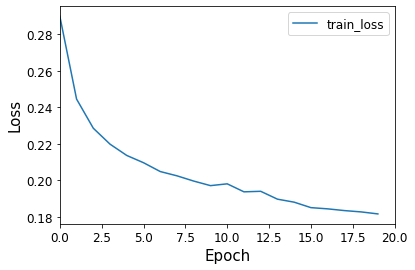

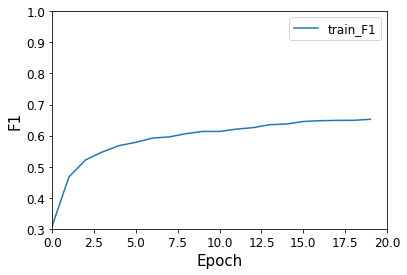

In [ ]:
tloss = Train_loss1
import matplotlib.pyplot as plt

x = [i for i in range(0,len(tloss))]

plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.plot(x, tloss, label="train_loss")

plt.tick_params(labelsize=12)
plt.legend(prop={"size": 12})
plt.xlim([0, 20])
plt.show()

tacc = F1_train_list1


import matplotlib.pyplot as plt

x = [i for i in range(0,len(tacc))]
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('F1', fontsize=15)

plt.plot(x, tacc, label="train_F1")
plt.ylim([0.3,1])
plt.xlim([0, 20])
plt.tick_params(labelsize=12)
plt.legend(prop={"size": 12})

plt.show()

In [ ]:
# n_splits分割（ここでは5分割）してCV
max_epoch_acc = 0
last_I = 100
# tsvファイルで保存する
tr_df2 = All_CATEGORY2[:30000]
tr_df4 = tr_df2[:25000]
tr_df3 = tr_df2[25000:]

# 全体の2割の文章数
tr_df = tr_df.sample(frac=1)
len_0_2 = 5000

I = 0

kf = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, valid_idx in kf.split(tr_df4):
  ls = np.array(tr_df4)
  #trainデータをリスト
  ls_train = ls[train_idx]
  #そのリストをデータフレームに
  ls_df1 = pd.DataFrame(ls_train)

  #valデータをリスト
  ls_val = ls[valid_idx]
  #そのリストをデータフレームに
  ls_df2 = pd.DataFrame(ls_val)

  # モデル構築
  BERT_net = BertForReview()

  # 訓練モードに設定
  BERT_net.train()
  print('ネットワーク設定完了')
  
  # 1. まず全部を、勾配計算Falseにしてしまう
  for param in BERT_net.parameters():
    param.requires_grad = False

  # 2. BertLayerモジュールの最後を勾配計算ありに変更
  for param in BERT_net.bert.encoder.layer[-1].parameters():
    param.requires_grad = True

  # 3. 識別器を勾配計算ありに変更
  for param in BERT_net.cls.parameters():
    param.requires_grad = True

  # BERTの元の部分はファインチューニング
  bert_optimizer = optim.Adam([
    {'params': BERT_net.bert.encoder.layer[-1].parameters(), 'lr': 5e-4},
    {'params': BERT_net.cls.parameters(), 'lr': 1e-3}
])

# tsvファイルで保存する

# 前2割からを訓練&検証データとする
  ls_df1.to_csv("./train.tsv", sep='\t', index=False, header=None)
# 前2割からを訓練&検証データとする
  ls_df2.to_csv("./val.tsv", sep='\t', index=False, header=None)
  
  # 前から2割をテストデータとする
  tr_df3.to_csv("./test.tsv", sep='\t', index=False, header=None)
  # 前2割からを訓練&検証データとする
  #tr_df4.to_csv("./train2.tsv", sep='\t', index=False, header=None)
  
  # 各tsvファイルを読み込み、分かち書きをしてdatasetにします
# 少し時間がかかります
# train_eval：61300個、test：15324個
  dataset_train, dataset_val = torchtext.legacy.data.TabularDataset.splits(
    path='.', train='train.tsv', test='val.tsv', format='tsv', fields=[('Text', TEXT), ('Label1', LABEL1), ('Label2', LABEL2), ('Label3', LABEL3),  ('Label4', LABEL4), ('Label5', LABEL5), ('Label6', LABEL6), ('Label7', LABEL7), ('Label8', LABEL8), ('Label9', LABEL9), ('Label10', LABEL10), ('Label11', LABEL11), ('Label12', LABEL12), ('Label13', LABEL13), ('Label14', LABEL14)])

  dataset_test = torchtext.legacy.data.TabularDataset(
    path='test.tsv', format='tsv', fields=[('Text', TEXT), ('Label1', LABEL1), ('Label2', LABEL2), ('Label3', LABEL3),  ('Label4', LABEL4), ('Label5', LABEL5), ('Label6', LABEL6), ('Label7', LABEL7), ('Label8', LABEL8), ('Label9', LABEL9), ('Label10', LABEL10), ('Label11', LABEL11), ('Label12', LABEL12), ('Label13', LABEL13), ('Label14', LABEL14)])

 #train_eval：4000個、test：2000個

  # torchtext.data.Datasetのsplit関数で訓練データと検証データを分ける
# train_eval：61300個、test：15324個

  #dataset_train, dataset_eval = dataset_train_eval.split(split_ratio = 0.8, random_state=random.seed(1234))
  
  batch_size = 4
  dl_train = torchtext.legacy.data.Iterator(
    dataset_train, batch_size=batch_size, train=True)
  dl_val = torchtext.legacy.data.Iterator(
    dataset_val, batch_size=batch_size, train=False, sort=False)
  dl_test = torchtext.legacy.data.Iterator(dataset_test, batch_size=batch_size, train=True)
  #dl_test = torchtext.legacy.data.Iterator(dataset_test, batch_size=batch_size, train=False, sort=False)
  # datasetの長さを確認してみる
  print(dataset_train.__len__())
  print(dataset_val.__len__())
  print(dataset_test.__len__())
  # 辞書オブジェクトにまとめる
  dataloaders_dict = {"train": dl_train, "val": dl_val}
  # 学習・検証を実行する。

  num_epochs = 20
  net_trained, trainloss, valloss, Ftrain, Fval, Pretrain1, Preval1, Rectrain1, Recval1,  PRED_LIST1 = train_model(BERT_net,  dataloaders_dict,criterion, bert_optimizer, num_epochs=num_epochs)

  # 勾配計算を最後のBertLayerモジュールと追加した分類アダプターのみ実行


  # 損失関数の設定
  criterion = nn.BCELoss()

  # モデル構築
  #TC_net = TransformerClassification()
  # ネットワークの初期化を定義
  #def weights_init(m):
    #classname = m.__class__.__name__
    #if classname.find('Linear') != -1:
      # Liner層の初期化
      #nn.init.kaiming_normal_(m.weight)
      #if m.bias is not None:
        #nn.init.constant_(m.bias, 0.0)
  # TransformerBlockモジュールを初期化実行
  #TC_net.net3_1.apply(weights_init)
  #TC_net.net3_2.apply(weights_init)
  #print('ネットワーク設定完了')

  # 損失関数の設定
  #criterion = nn.CrossEntropyLoss()
  # nn.LogSoftmax()を計算してからnn.NLLLoss(negative log likelihood loss)を計算

  # 最適化手法の設定
  #learning_rate = 2e-5
  #optimizer = optim.Adam(TC_net.parameters(), lr=learning_rate)


########################テストデータでの正解率を求める#############################################

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  net_trained.eval()   # モデルを検証モードに
  net_trained.to(device)  # GPUが使えるならGPUへ送る

# epochの正解数を記録する変数
  epoch_corrects = 0
  pred_list1 = []
  label_list1 = []
  aa1 = 0
  bb1 = 0

  acc_count=0
  part_acc_count=0
  all_miss=0

  for batch in tqdm(dl_test): 
    inputs = batch.Text[0].to(device)  # 文章
    labels0 = batch.Label1.to(device)  # ラベル
    labels1 = batch.Label2.to(device)
    labels2 = batch.Label3.to(device)
    labels3 = batch.Label4.to(device)
    labels4 = batch.Label5.to(device)
    labels5 = batch.Label6.to(device)
    labels6 = batch.Label7.to(device)
    labels7 = batch.Label8.to(device)
    labels8 = batch.Label9.to(device)
    labels9 = batch.Label10.to(device)
    labels10 = batch.Label11.to(device)
    labels11 = batch.Label12.to(device)
    labels12 = batch.Label13.to(device)
    labels13 = batch.Label14.to(device)
    pa = torch.stack([labels0, labels1, labels2, labels3, labels4,labels5,labels6,labels7,labels8,labels9, labels10, labels11,labels12,labels13], dim = 1)
    pa2 = pa.cpu().numpy()
      

    Outputs = net_trained(inputs)

    preds = torch.round(Outputs)

    aa1 = preds.cpu().detach().numpy()
    bb1 = pa.cpu().detach().numpy()
    pred_list1 = np.append(pred_list1, aa1)
    label_list1 = np.append(label_list1, bb1)

  precisionscore = precision_score(pred_list1.reshape(int(len(pred_list1)/14), 14), label_list1.reshape(int(len(label_list1)/14), 14), average= 'micro') 
  recallscore = recall_score(pred_list1.reshape(int(len(pred_list1)/14), 14), label_list1.reshape(int(len(label_list1)/14), 14), average= 'micro')
  epoch_f1 = f1_score(pred_list1.reshape(int(len(pred_list1)/14), 14), label_list1.reshape(int(len(label_list1)/14), 14), average= 'micro')
        
  print('テストデータ{}個での正解率：{:.4f}'.format(len(dl_test.dataset), precisionscore))
        
  print('テストデータ{}個での正解率：{:.4f}'.format(len(dl_test.dataset), recallscore))
        
  print('テストデータ{}個での正解率：{:.4f}'.format(len(dl_test.dataset), epoch_f1))

  PRED_LIST = pred_list1.reshape(int(len(pred_list1)/14), 14)
  LABEL_LIST = label_list1.reshape(int(len(label_list1)/14), 14)

  for i in range(len(PRED_LIST)):
    if (PRED_LIST[i]==LABEL_LIST[i]).all():
      acc_count+=1
    elif (PRED_LIST[i]==LABEL_LIST[i]).any():
      part_acc_count+=1
  all_miss = len(dl_test.dataset) - (acc_count + part_acc_count)
  
  print("######################################################")
  print("ACC_COUNT", acc_count)
  print("PART_ACC_COUNT", part_acc_count)
  print("ALL_MISS", all_miss)
  
  if I == 0:
    net_trained_1, Train_loss1, Val_loss1, F1_train_list1, F1_val_list1 = net_trained, trainloss, valloss, Ftrain, Fval
    I=1
    dl_train1, dl_eval1 = dl_train, dl_val

  elif I == 1:
    net_trained_2, Train_loss2, Val_loss2, F1_train_list2, F1_val_list2 = net_trained, trainloss, valloss, Ftrain, Fval
    I=2
    dl_train2, dl_eval2 = dl_train, dl_val

  elif I == 2:
    net_trained_3, Train_loss3, Val_loss3, F1_train_list3, F1_val_list3 = net_trained, trainloss, valloss, Ftrain, Fval
    I=3
    dl_train3, dl_eval3 = dl_train, dl_val

  elif I == 3:
    net_trained_4, Train_loss4, Val_loss4, F1_train_list4, F1_val_list4 = net_trained, trainloss, valloss, Ftrain, Fval
    I=4
    dl_train4, dl_eval4 = dl_train, dl_val

  elif I == 4:
    net_trained_5, Train_loss5, Val_loss5, F1_train_list5, F1_val_list5 = net_trained, trainloss, valloss, Ftrain, Fval
    I=5
    dl_train5, dl_eval5 = dl_train, dl_val


  if max_epoch_acc < epoch_f1:
    max_epoch_acc = epoch_f1
    last_I = I

ネットワーク設定完了
20000
5000
5000
f1 0.3562770848456851
precision 0.24474129593810445
recaoll 0.6545954247837685
Epoch of BERT 1/20 | train | Loss: 0.2797 F1: 0.3563
f1 0.5272170151405912
precision 0.4420031431334623
recaoll 0.6531350482315113
Epoch of BERT 1/20 |  val  | Loss: 0.9603 F1: 0.5272
f1 0.4748774387193597
precision 0.35861943907156674
recaoll 0.7026706934328182
Epoch of BERT 2/20 | train | Loss: 0.2431 F1: 0.4749
f1 0.5803479112626748
precision 0.4834683268858801
recaoll 0.7257837666167597
Epoch of BERT 2/20 |  val  | Loss: 0.8714 F1: 0.5803
f1 0.5115560021643348
precision 0.40002417794970985
recaoll 0.7093247588424437
Epoch of BERT 3/20 | train | Loss: 0.2310 F1: 0.5116
f1 0.5262350233134628
precision 0.4041948742746615
recaoll 0.753847021024745
Epoch of BERT 3/20 |  val  | Loss: 0.8709 F1: 0.5262
f1 0.5370104339936488
precision 0.42930971953578334
recaoll 0.7168449737585789
Epoch of BERT 4/20 | train | Loss: 0.2217 F1: 0.5370
f1 0.6047704635662399
precision 0.488122582205029
rec

100%|██████████| 1250/1250 [00:13<00:00, 93.38it/s]


テストデータ5000個での正解率：0.5835
テストデータ5000個での正解率：0.7925
テストデータ5000個での正解率：0.6721
######################################################
ACC_COUNT 2425
PART_ACC_COUNT 2575
ALL_MISS 0
ネットワーク設定完了
20000
5000
5000
f1 0.3306920469595277
precision 0.22216190131499577
recaoll 0.6465373474940753
Epoch of BERT 1/20 | train | Loss: 0.2845 F1: 0.3307
f1 0.5321845682557916
precision 0.4191699843165641
recaoll 0.728635839362483
Epoch of BERT 1/20 |  val  | Loss: 0.8965 F1: 0.5322
f1 0.4758538522637013
precision 0.3613825551936301
recaoll 0.6964659381539177
Epoch of BERT 2/20 | train | Loss: 0.2420 F1: 0.4759
f1 0.5746934844612365
precision 0.46793943780914465
recaoll 0.7445532200787024
Epoch of BERT 2/20 |  val  | Loss: 0.8270 F1: 0.5747
f1 0.5059698043444769
precision 0.3962178791169019
recaoll 0.6998188791817601
Epoch of BERT 3/20 | train | Loss: 0.2311 F1: 0.5060
f1 0.5935845749342682
precision 0.5106768005790807
recaoll 0.7086297815351135
Epoch of BERT 3/20 |  val  | Loss: 0.8737 F1: 0.5936
f1 0.54441509

100%|██████████| 1250/1250 [00:13<00:00, 92.08it/s]


テストデータ5000個での正解率：0.6029
テストデータ5000個での正解率：0.8037
テストデータ5000個での正解率：0.6890
######################################################
ACC_COUNT 2516
PART_ACC_COUNT 2484
ALL_MISS 0
ネットワーク設定完了
20000
5000
5000
f1 0.38002457055413064
precision 0.26738649115889723
recaoll 0.6566363771786087
Epoch of BERT 1/20 | train | Loss: 0.2725 F1: 0.3800
f1 0.5132182407994332
precision 0.4174577659155015
recaoll 0.6659892582377703
Epoch of BERT 1/20 |  val  | Loss: 0.9279 F1: 0.5132
f1 0.4913647271725874
precision 0.37881774893087866
recaoll 0.6990541221245872
Epoch of BERT 2/20 | train | Loss: 0.2381 F1: 0.4914
f1 0.5612531746185612
precision 0.43902217099875646
recaoll 0.777807630306287
Epoch of BERT 2/20 |  val  | Loss: 0.8143 F1: 0.5613
f1 0.5239757061602236
precision 0.4121197415910952
recaoll 0.7191701069122473
Epoch of BERT 3/20 | train | Loss: 0.2267 F1: 0.5240
f1 0.5956632169528792
precision 0.47657031937156896
recaoll 0.7941072421286703
Epoch of BERT 3/20 |  val  | Loss: 0.7863 F1: 0.5957
f1 0.55200

100%|██████████| 1250/1250 [00:14<00:00, 88.52it/s]


テストデータ5000個での正解率：0.5543
テストデータ5000個での正解率：0.7770
テストデータ5000個での正解率：0.6470
######################################################
ACC_COUNT 2161
PART_ACC_COUNT 2839
ALL_MISS 0
ネットワーク設定完了
20000
5000
5000
f1 0.3359047232372446
precision 0.2263428276134602
recaoll 0.6510448544198654
Epoch of BERT 1/20 | train | Loss: 0.2821 F1: 0.3359
f1 0.4559237833071679
precision 0.32221783141319876
recaoll 0.779297162182032
Epoch of BERT 1/20 |  val  | Loss: 0.9349 F1: 0.4559
f1 0.46739152361164343
precision 0.35215977140772714
recaoll 0.6947109618613576
Epoch of BERT 2/20 | train | Loss: 0.2437 F1: 0.4674
f1 0.5897095179233622
precision 0.5800832902696295
recaoll 0.599660622819973
Epoch of BERT 2/20 |  val  | Loss: 0.9769 F1: 0.5897
f1 0.4969751906516641
precision 0.383317627747211
recaoll 0.7064425770308124
Epoch of BERT 3/20 | train | Loss: 0.2342 F1: 0.4970
f1 0.5883066740209597
precision 0.48633614007356296
recaoll 0.7443818917787186
Epoch of BERT 3/20 |  val  | Loss: 0.8232 F1: 0.5883
f1 0.51856740

100%|██████████| 1250/1250 [00:14<00:00, 88.24it/s]


テストデータ5000個での正解率：0.6331
テストデータ5000個での正解率：0.7710
テストデータ5000個での正解率：0.6952
######################################################
ACC_COUNT 2537
PART_ACC_COUNT 2461
ALL_MISS 2
ネットワーク設定完了
20000
5000
5000
f1 0.31859340256286817
precision 0.21083131067961164
recaoll 0.6516927693894776
Epoch of BERT 1/20 | train | Loss: 0.2867 F1: 0.3186
f1 0.5107989561934374
precision 0.4186893203883495
recaoll 0.6548664167418023
Epoch of BERT 1/20 |  val  | Loss: 0.9789 F1: 0.5108
f1 0.46046001300390116
precision 0.34378033980582523
recaoll 0.6970349409448819
Epoch of BERT 2/20 | train | Loss: 0.2459 F1: 0.4605
f1 0.5533638195628584
precision 0.43322208737864076
recaoll 0.7657121407121407
Epoch of BERT 2/20 |  val  | Loss: 0.8241 F1: 0.5534
f1 0.5122931626600064
precision 0.3982706310679612
recaoll 0.7177930883639545
Epoch of BERT 3/20 | train | Loss: 0.2309 F1: 0.5123
f1 0.6090997800307626
precision 0.5586771844660194
recaoll 0.6695269606951969
Epoch of BERT 3/20 |  val  | Loss: 0.8965 F1: 0.6091
f1 0.5370

100%|██████████| 1250/1250 [00:14<00:00, 88.50it/s]


テストデータ5000個での正解率：0.6069
テストデータ5000個での正解率：0.7885
テストデータ5000個での正解率：0.6859
######################################################
ACC_COUNT 2441
PART_ACC_COUNT 2559
ALL_MISS 0


In [ ]:
import statistics
import math

PR_l2 = [0.6342, 0.5348,0.5453, 0.5947, 0.5864]
RE_l2 = [0.7317 ,0.8005, 0.7814, 0.7885, 0.7707]
F1_l2 = [0.6795, 0.6412, 0.7326, 0.6780,0.6660]

mean = statistics.mean(PR_l2)
print(mean)
pstdev = statistics.pstdev(PR_l2)
print(pstdev)

mean = statistics.mean(RE_l2)
print(mean)
pstdev = statistics.pstdev(RE_l2)
print(pstdev)

mean = statistics.mean(F1_l2)
print(mean)
pstdev = statistics.pstdev(F1_l2)
print(pstdev)

0.57908
0.03588199548520119
0.77456
0.02351965986148608
0.6794600000000001
0.029903150335708787


In [ ]:
rint(a)

In [ ]:
num_epochs = 30
net_trained1,trainloss1, valloss1, Ftrain1, Fval1, Pretrain, Preval, Rectrain, Recval,  PRED_LIST  = train_model(BERT_net,  dataloaders_dict, criterion, bert_optimizer, num_epochs=num_epochs)

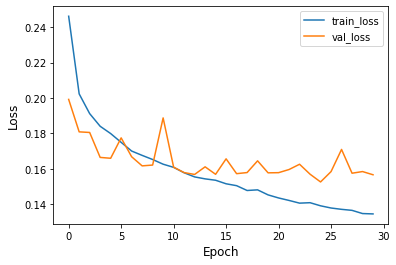

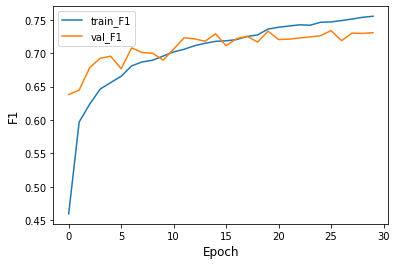

In [ ]:
tloss = trainloss1
vloss = valloss1

import matplotlib.pyplot as plt

x = [i for i in range(0,len(tloss))]

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)

plt.plot(x, tloss, label="train_loss")
plt.plot(x, vloss, label="val_loss")

plt.tick_params(labelsize=10)
plt.legend(prop={"size": 10})

plt.show()

tacc = Ftrain1
vacc = Fval1

import matplotlib.pyplot as plt

x = [i for i in range(0,len(tacc))]

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('F1', fontsize=12)

plt.plot(x, tacc, label="train_F1")
plt.plot(x, vacc, label="val_F1")

plt.tick_params(labelsize=10)
plt.legend(prop={"size": 10})

plt.show()

In [ ]:
from tqdm import tqdm

labels_numpy = 0
preds_numpy = 0

aa = []
bb = []
pred_list=[]
label_list = []

# テストデータでの正解率を求める
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net_trained1.eval()   # モデルを検証モードに
net_trained1.to(device)  # GPUが使えるならGPUへ送る

# epochの正解数を記録する変数
epoch_corrects = 0

a = [[0, 0],
     [0, 0]]

for batch in tqdm(dl_test):  # testデータのDataLoader
    # batchはTextとLableの辞書オブジェクト
    # GPUが使えるならGPUにデータを送る
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    inputs = batch.Text[0].to(device)  # 文章
    labels = batch.Label1.to(device)  # ラベル
    labels2 = batch.Label2.to(device)
    labels3 = batch.Label3.to(device)
    labels4 = batch.Label4.to(device)
    labels5 = batch.Label5.to(device)
    labels6 = batch.Label6.to(device)
    labels7 = batch.Label7.to(device)
    labels8 = batch.Label8.to(device)
    labels9 = batch.Label9.to(device)
    labels10 = batch.Label10.to(device)
    labels11 = batch.Label11.to(device)
    labels12 = batch.Label12.to(device)
    labels13 = batch.Label12.to(device)
    labels14 = batch.Label12.to(device)
    pa = torch.stack([labels, labels2, labels3, labels4, labels5,labels6,labels7,labels8,labels9,labels10, labels11, labels12, labels13, labels14], dim = 1)
                
    pa = torch.tensor(pa, dtype=torch.float32)


    # 順伝搬（forward）計算
    with torch.set_grad_enabled(False):

        # BertForReviewに入力
        outputs = net_trained1(inputs)

        loss = criterion(outputs, pa)  # 損失を計算

        ang = torch.round(outputs)
        aa = ang.cpu().detach().numpy()
        bb = pa.cpu().detach().numpy()
        pred_list = np.append(pred_list, aa)
        label_list = np.append(label_list, bb)
                  
precisionscore = precision_score(pred_list.reshape(int(len(pred_list)/14), 14), label_list.reshape(int(len(label_list)/14), 14), average= 'micro')
recallscore = recall_score(pred_list.reshape(int(len(pred_list)/14), 14), label_list.reshape(int(len(label_list)/14), 14), average= 'micro')
f1score = f1_score(pred_list.reshape(int(len(pred_list)/14), 14), label_list.reshape(int(len(label_list)/14), 14), average= 'micro')

print('テストデータ3000個での正解率：', precisionscore)        
print('テストデータ3000個での正解率：', recallscore)
print('テストデータ3000個での正解率：', f1score)

100%|██████████| 750/750 [00:08<00:00, 90.21it/s]

テストデータ3000個での正解率： 0.6219731839103462
テストデータ3000個での正解率： 0.7095890410958904
テストデータ3000個での正解率： 0.6628985816359176


In [ ]:
All_CATEGORY2 = All_CATEGORY.sample(frac=1)

# tsvファイルで保存する
tr_df = All_CATEGORY2[:24000]
# 全体の2割の文章数
tr_df = tr_df.sample(frac=1)
len_0_2 = 3000

# 前から2割をテストデータとする
tr_df[:len_0_2].to_csv("./test.tsv", sep='\t', index=False, header=None)
print(tr_df[:len_0_2].shape)

# 前2割からを訓練&検証データとする
tr_df[len_0_2:].to_csv("./train.tsv", sep='\t', index=False, header=None)
print(tr_df[len_0_2:].shape)

In [ ]:
# n_splits分割（ここでは5分割）してCV
max_epoch_acc = 0
last_I = 100
# tsvファイルで保存する
tr_df2 = All_CATEGORY2[:24000]
tr_df4 = tr_df2[:20000]
tr_df3 = tr_df2[20000:]

# 全体の2割の文章数
tr_df = tr_df.sample(frac=1)
len_0_2 = 4000

I = 0

kf = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, valid_idx in kf.split(tr_df4):
  ls = np.array(tr_df4)
  #trainデータをリスト
  ls_train = ls[train_idx]
  #そのリストをデータフレームに
  ls_df1 = pd.DataFrame(ls_train)

  #valデータをリスト
  ls_val = ls[valid_idx]
  #そのリストをデータフレームに
  ls_df2 = pd.DataFrame(ls_val)

  # モデル構築
  BERT_net = BertForReview()

  # 訓練モードに設定
  BERT_net.train()
  print('ネットワーク設定完了')
  
  # 1. まず全部を、勾配計算Falseにしてしまう
  for param in BERT_net.parameters():
    param.requires_grad = False

  # 2. BertLayerモジュールの最後を勾配計算ありに変更
  for param in BERT_net.bert.encoder.layer[-1].parameters():
    param.requires_grad = True

  # 3. 識別器を勾配計算ありに変更
  for param in BERT_net.cls.parameters():
    param.requires_grad = True

  # BERTの元の部分はファインチューニング
  bert_optimizer = optim.Adam([
    {'params': BERT_net.bert.encoder.layer[-1].parameters(), 'lr': 1e-4},
    {'params': BERT_net.cls.parameters(), 'lr': 1e-3}
])

# tsvファイルで保存する

# 前2割からを訓練&検証データとする
  ls_df1.to_csv("./train.tsv", sep='\t', index=False, header=None)
# 前2割からを訓練&検証データとする
  ls_df2.to_csv("./val.tsv", sep='\t', index=False, header=None)
  
  # 前から2割をテストデータとする
  tr_df3.to_csv("./test.tsv", sep='\t', index=False, header=None)
  # 前2割からを訓練&検証データとする
  #tr_df4.to_csv("./train2.tsv", sep='\t', index=False, header=None)
  
  # 各tsvファイルを読み込み、分かち書きをしてdatasetにします
# 少し時間がかかります
# train_eval：61300個、test：15324個
  dataset_train, dataset_val = torchtext.legacy.data.TabularDataset.splits(
    path='.', train='train.tsv', test='val.tsv', format='tsv', fields=[('Text', TEXT), ('Label1', LABEL1), ('Label2', LABEL2), ('Label3', LABEL3),  ('Label4', LABEL4), ('Label5', LABEL5), ('Label6', LABEL6), ('Label7', LABEL7), ('Label8', LABEL8), ('Label9', LABEL9), ('Label10', LABEL10), ('Label11', LABEL11), ('Label12', LABEL12), ('Label13', LABEL13), ('Label14', LABEL14)])

  dataset_test = torchtext.legacy.data.TabularDataset(
    path='test.tsv', format='tsv', fields=[('Text', TEXT), ('Label1', LABEL1), ('Label2', LABEL2), ('Label3', LABEL3),  ('Label4', LABEL4), ('Label5', LABEL5), ('Label6', LABEL6), ('Label7', LABEL7), ('Label8', LABEL8), ('Label9', LABEL9), ('Label10', LABEL10), ('Label11', LABEL11), ('Label12', LABEL12), ('Label13', LABEL13), ('Label14', LABEL14)])

 #train_eval：4000個、test：2000個

  # torchtext.data.Datasetのsplit関数で訓練データと検証データを分ける
# train_eval：61300個、test：15324個

  #dataset_train, dataset_eval = dataset_train_eval.split(split_ratio = 0.8, random_state=random.seed(1234))
  
  batch_size = 4
  dl_train = torchtext.legacy.data.Iterator(
    dataset_train, batch_size=batch_size, train=True)
  dl_val = torchtext.legacy.data.Iterator(
    dataset_val, batch_size=batch_size, train=False, sort=False)
  dl_test = torchtext.legacy.data.Iterator(dataset_test, batch_size=batch_size, train=True)
  #dl_test = torchtext.legacy.data.Iterator(dataset_test, batch_size=batch_size, train=False, sort=False)
  # datasetの長さを確認してみる
  print(dataset_train.__len__())
  print(dataset_val.__len__())
  print(dataset_test.__len__())
  # 辞書オブジェクトにまとめる
  dataloaders_dict = {"train": dl_train, "val": dl_val}
  # 学習・検証を実行する。

  num_epochs = 15
  net_trained, trainloss, valloss, Ftrain, Fval, Pretrain1, Preval1, Rectrain1, Recval1,  PRED_LIST1 = train_model(BERT_net,  dataloaders_dict,criterion, bert_optimizer, num_epochs=num_epochs)

  # 勾配計算を最後のBertLayerモジュールと追加した分類アダプターのみ実行


  # 損失関数の設定
  criterion = nn.BCELoss()

  # モデル構築
  #TC_net = TransformerClassification()
  # ネットワークの初期化を定義
  #def weights_init(m):
    #classname = m.__class__.__name__
    #if classname.find('Linear') != -1:
      # Liner層の初期化
      #nn.init.kaiming_normal_(m.weight)
      #if m.bias is not None:
        #nn.init.constant_(m.bias, 0.0)
  # TransformerBlockモジュールを初期化実行
  #TC_net.net3_1.apply(weights_init)
  #TC_net.net3_2.apply(weights_init)
  #print('ネットワーク設定完了')

  # 損失関数の設定
  #criterion = nn.CrossEntropyLoss()
  # nn.LogSoftmax()を計算してからnn.NLLLoss(negative log likelihood loss)を計算

  # 最適化手法の設定
  #learning_rate = 2e-5
  #optimizer = optim.Adam(TC_net.parameters(), lr=learning_rate)


########################テストデータでの正解率を求める#############################################

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  net_trained.eval()   # モデルを検証モードに
  net_trained.to(device)  # GPUが使えるならGPUへ送る

# epochの正解数を記録する変数
  epoch_corrects = 0
  pred_list1 = []
  label_list1 = []
  aa1 = 0
  bb1 = 0

  for batch in tqdm(dl_test): 
    inputs = batch.Text[0].to(device)  # 文章
    labels0 = batch.Label1.to(device)  # ラベル
    labels1 = batch.Label2.to(device)
    labels2 = batch.Label3.to(device)
    labels3 = batch.Label4.to(device)
    labels4 = batch.Label5.to(device)
    labels5 = batch.Label6.to(device)
    labels6 = batch.Label7.to(device)
    labels7 = batch.Label8.to(device)
    labels8 = batch.Label9.to(device)
    labels9 = batch.Label10.to(device)
    labels10 = batch.Label11.to(device)
    labels11 = batch.Label12.to(device)
    labels12 = batch.Label13.to(device)
    labels13 = batch.Label14.to(device)
    pa = torch.stack([labels0, labels1, labels2, labels3, labels4,labels5,labels6,labels7,labels8,labels9, labels10, labels11,labels12,labels13], dim = 1)
    pa2 = pa.cpu().numpy()
      

    Outputs = net_trained(inputs)

    preds = torch.round(Outputs)

    aa1 = preds.cpu().detach().numpy()
    bb1 = pa.cpu().detach().numpy()
    pred_list1 = np.append(pred_list1, aa1)
    label_list1 = np.append(label_list1, bb1)

  precisionscore = precision_score(pred_list1.reshape(int(len(pred_list1)/14), 14), label_list1.reshape(int(len(label_list1)/14), 14), average= 'micro') 
  recallscore = recall_score(pred_list1.reshape(int(len(pred_list1)/14), 14), label_list1.reshape(int(len(label_list1)/14), 14), average= 'micro')
  epoch_f1 = f1_score(pred_list1.reshape(int(len(pred_list1)/14), 14), label_list1.reshape(int(len(label_list1)/14), 14), average= 'micro')
        
  print('テストデータ{}個での正解率：{:.4f}'.format(len(dl_test.dataset), precisionscore))
        
  print('テストデータ{}個での正解率：{:.4f}'.format(len(dl_test.dataset), recallscore))
        
  print('テストデータ{}個での正解率：{:.4f}'.format(len(dl_test.dataset), epoch_f1))

  if I == 0:
    net_trained_1, Train_loss1, Val_loss1, F1_train_list1, F1_val_list1 = net_trained, trainloss, valloss, Ftrain, Fval
    I=1
    dl_train1, dl_eval1 = dl_train, dl_val

  elif I == 1:
    net_trained_2, Train_loss2, Val_loss2, F1_train_list2, F1_val_list2 = net_trained, trainloss, valloss, Ftrain, Fval
    I=2
    dl_train2, dl_eval2 = dl_train, dl_val

  elif I == 2:
    net_trained_3, Train_loss3, Val_loss3, F1_train_list3, F1_val_list3 = net_trained, trainloss, valloss, Ftrain, Fval
    I=3
    dl_train3, dl_eval3 = dl_train, dl_val

  elif I == 3:
    net_trained_4, Train_loss4, Val_loss4, F1_train_list4, F1_val_list4 = net_trained, trainloss, valloss, Ftrain, Fval
    I=4
    dl_train4, dl_eval4 = dl_train, dl_val

  elif I == 4:
    net_trained_5, Train_loss5, Val_loss5, F1_train_list5, F1_val_list5 = net_trained, trainloss, valloss, Ftrain, Fval
    I=5
    dl_train5, dl_eval5 = dl_train, dl_val


  if max_epoch_acc < epoch_f1:
    max_epoch_acc = epoch_f1
    last_I = I

ネットワーク設定完了
16000
4000
4000
f1 0.4565714429285696
precision 0.34258351557197797
recaoll 0.6842382709541381
Epoch of BERT 1/15 | train | Loss: 0.2516 F1: 0.4566
f1 0.6113110539845759
precision 0.5323086106551261
recaoll 0.7178506741799154
Epoch of BERT 1/15 |  val  | Loss: 0.2035 F1: 0.6113
f1 0.5796125064996722
precision 0.48333459015157226
recaoll 0.7237874767093897
Epoch of BERT 2/15 | train | Loss: 0.2107 F1: 0.5796
f1 0.6451612903225806
precision 0.5297716758692732
recaoll 0.824814126394052
Epoch of BERT 2/15 |  val  | Loss: 0.1776 F1: 0.6452
f1 0.612878200155159
precision 0.5212653646029711
recaoll 0.7435594040768031
Epoch of BERT 3/15 | train | Loss: 0.1987 F1: 0.6129
f1 0.6562290689886136
precision 0.5848380838680793
recaoll 0.7474728209040625
Epoch of BERT 3/15 |  val  | Loss: 0.1827 F1: 0.6562
f1 0.6294939568755622
precision 0.5410225473192067
recaoll 0.7525567734829811
Epoch of BERT 4/15 | train | Loss: 0.1919 F1: 0.6295
f1 0.7049870466321244
precision 0.6497537680943143
recao

100%|██████████| 1000/1000 [00:10<00:00, 93.87it/s]


テストデータ4000個での正解率：0.7169
ネットワーク設定完了
16000
4000
4000
f1 0.4340364309020373
precision 0.31771166359499003
recaoll 0.6847438391699092
Epoch of BERT 1/15 | train | Loss: 0.2584 F1: 0.4340
f1 0.5972874745146707
precision 0.5076853526220615
recaoll 0.7252960172228202
Epoch of BERT 1/15 |  val  | Loss: 0.2114 F1: 0.5973
f1 0.5760036289408029
precision 0.477601835483507
recaoll 0.7254756327486717
Epoch of BERT 2/15 | train | Loss: 0.2122 F1: 0.5760
f1 0.6272694909220363
precision 0.5310427968655816
recaoll 0.7660869565217391
Epoch of BERT 2/15 |  val  | Loss: 0.1861 F1: 0.6273
f1 0.6086898573903773
precision 0.5153270395305977
recaoll 0.7433671531658619
Epoch of BERT 3/15 | train | Loss: 0.1990 F1: 0.6087
f1 0.6601607347876004
precision 0.6065400843881856
recaoll 0.7241813602015114
Epoch of BERT 3/15 |  val  | Loss: 0.1899 F1: 0.6602
f1 0.6278105600280782
precision 0.5382329710008651
recaoll 0.7531578947368421
Epoch of BERT 4/15 | train | Loss: 0.1918 F1: 0.6278
f1 0.6893276680829793
precision 

100%|██████████| 1000/1000 [00:10<00:00, 92.84it/s]


テストデータ4000個での正解率：0.7179
ネットワーク設定完了
16000
4000
4000
f1 0.4452255418863503
precision 0.3298984637451402
recaoll 0.6845238095238095
Epoch of BERT 1/15 | train | Loss: 0.2556 F1: 0.4452
f1 0.6052208117289469
precision 0.5029717682020802
recaoll 0.7596499102333932
Epoch of BERT 1/15 |  val  | Loss: 0.1970 F1: 0.6052
f1 0.5767427036379366
precision 0.4781262975125505
recaoll 0.7266104514426662
Epoch of BERT 2/15 | train | Loss: 0.2124 F1: 0.5767
f1 0.6812742812742812
precision 0.6514115898959881
recaoll 0.7140065146579805
Epoch of BERT 2/15 |  val  | Loss: 0.1829 F1: 0.6813
f1 0.6095640569395019
precision 0.5172309666704412
recaoll 0.7420263172144907
Epoch of BERT 3/15 | train | Loss: 0.1993 F1: 0.6096
f1 0.6657244991271095
precision 0.5949479940564636
recaoll 0.7556142668428005
Epoch of BERT 3/15 |  val  | Loss: 0.1797 F1: 0.6657
f1 0.6293388612005469
precision 0.5385951005926094
recaoll 0.7568556728372142
Epoch of BERT 4/15 | train | Loss: 0.1927 F1: 0.6293
f1 0.6841140190031673
precision 

100%|██████████| 1000/1000 [00:10<00:00, 92.88it/s]


テストデータ4000個での正解率：0.6878
ネットワーク設定完了
16000
4000
4000
f1 0.41038434552116626
precision 0.2967194017511555
recaoll 0.665206402695872
Epoch of BERT 1/15 | train | Loss: 0.2662 F1: 0.4104
f1 0.6070427470217238
precision 0.5240471869328494
recaoll 0.7212739383846795
Epoch of BERT 1/15 |  val  | Loss: 0.2106 F1: 0.6070
f1 0.5580478863558254
precision 0.4576303032580512
recaoll 0.7149230949864976
Epoch of BERT 2/15 | train | Loss: 0.2193 F1: 0.5580
f1 0.562205910031997
precision 0.4517543859649123
recaoll 0.7441454907822621
Epoch of BERT 2/15 |  val  | Loss: 0.2233 F1: 0.5622
f1 0.5912343067992619
precision 0.49374318890684304
recaoll 0.7366975049060835
Epoch of BERT 3/15 | train | Loss: 0.2070 F1: 0.5912
f1 0.6411568770818101
precision 0.5967937084089534
recaoll 0.692645251886958
Epoch of BERT 3/15 |  val  | Loss: 0.1951 F1: 0.6412
f1 0.6129175157260566
precision 0.5199353650745933
recaoll 0.7463990937044829
Epoch of BERT 4/15 | train | Loss: 0.1977 F1: 0.6129
f1 0.6740350574216388
precision 0

100%|██████████| 1000/1000 [00:10<00:00, 93.54it/s]


テストデータ4000個での正解率：0.6886
ネットワーク設定完了
16000
4000
4000
f1 0.44023782904766745
precision 0.3247123205517448
recaoll 0.6833635718229865
Epoch of BERT 1/15 | train | Loss: 0.2576 F1: 0.4402
f1 0.6149659863945578
precision 0.5871026894865525
recaoll 0.6456057805410855
Epoch of BERT 1/15 |  val  | Loss: 0.2158 F1: 0.6150
f1 0.5819313517658201
precision 0.4836013343828479
recaoll 0.7304534903470532
Epoch of BERT 2/15 | train | Loss: 0.2122 F1: 0.5819
f1 0.6133955826898905
precision 0.5220048899755502
recaoll 0.7435785807575098
Epoch of BERT 2/15 |  val  | Loss: 0.2032 F1: 0.6134
f1 0.6083567680077944
precision 0.514899359046441
recaoll 0.7432637160480468
Epoch of BERT 3/15 | train | Loss: 0.2011 F1: 0.6084
f1 0.6752024681835711
precision 0.6688569682151589
recaoll 0.6816695218813269
Epoch of BERT 3/15 |  val  | Loss: 0.1901 F1: 0.6752
f1 0.629724241828781
precision 0.5405375014055999
recaoll 0.7541575149042987
Epoch of BERT 4/15 | train | Loss: 0.1926 F1: 0.6297
f1 0.6602838666330729
precision 0

100%|██████████| 1000/1000 [00:10<00:00, 92.92it/s]

テストデータ4000個での正解率：0.7217


In [ ]:
l = [0.7169,0.7179,0.6878,0.6886,0.7217]
import statistics
import math

In [ ]:
mean = statistics.mean(l)
print(mean)
pstdev = statistics.pstdev(l)
print(pstdev)

0.70658
0.015094555309779756


In [ ]:
import numpy as np
from sklearn.model_selection import KFold

x = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [3, 4], [3, 4], [3, 4], [3, 4], [3, 4], [3, 4]])
y = np.array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

kf = KFold(n_splits=5, shuffle=True)
for train_index, test_index in kf.split(x, y):
    print("train_index:", train_index, "test_index:", test_index)
    print("x_train", x[train_index])

# output
# train_index: [2 3 4 5 6 7 8 9] test_index: [0 1]
# train_index: [0 1 4 5 6 7 8 9] test_index: [2 3]
# train_index: [0 1 2 3 6 7 8 9] test_index: [4 5]
# train_index: [0 1 2 3 4 5 8 9] test_index: [6 7]
# train_index: [0 1 2 3 4 5 6 7] test_index: [8 9]

train_index: [0 1 2 3 4 5 6 9] test_index: [7 8]
x_train [[1 2]
 [3 4]
 [1 2]
 [3 4]
 [3 4]
 [3 4]
 [3 4]
 [3 4]]
train_index: [0 1 2 4 5 6 7 8] test_index: [3 9]
x_train [[1 2]
 [3 4]
 [1 2]
 [3 4]
 [3 4]
 [3 4]
 [3 4]
 [3 4]]
train_index: [0 2 3 4 5 7 8 9] test_index: [1 6]
x_train [[1 2]
 [1 2]
 [3 4]
 [3 4]
 [3 4]
 [3 4]
 [3 4]
 [3 4]]
train_index: [1 3 4 5 6 7 8 9] test_index: [0 2]
x_train [[3 4]
 [3 4]
 [3 4]
 [3 4]
 [3 4]
 [3 4]
 [3 4]
 [3 4]]
train_index: [0 1 2 3 6 7 8 9] test_index: [4 5]
x_train [[1 2]
 [3 4]
 [1 2]
 [3 4]
 [3 4]
 [3 4]
 [3 4]
 [3 4]]


In [ ]:
lo = [1,2,3,4,5,6,7,8,9,0]
lo[:0]+lo[0+2:]

[3, 4, 5, 6, 7, 8, 9, 0]